In [1]:
import torch
import random
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

class SignalClassifier(nn.Module):
    def __init__(self, input_channels, filter_size, win_len):
        super(SignalClassifier, self).__init__()

        # Initial convolution layer with increased filters
        self.conv1 = nn.Conv1d(in_channels=input_channels, out_channels=2, kernel_size=filter_size, padding='same')
        self.bn1 = nn.BatchNorm1d(2)  # BatchNorm layer after the first conv layer
        self.prelu1 = nn.PReLU()

        # Branch 1: Convolution layers followed by output layer
        self.branch1_layers = nn.ModuleList()
        self.branch1_bns = nn.ModuleList()  # BatchNorm layers for branch 1
        for i in range(2):
            self.branch1_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch1_bns.append(nn.BatchNorm1d(8))
        self.branch1_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch1 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch1 = nn.Linear(8*win_len, 128)
        self.fc2_branch1 = nn.Linear(128, 1)
        
        # Branch 2: Convolution layers followed by output layer
        self.branch2_layers = nn.ModuleList()
        self.branch2_bns = nn.ModuleList()  # BatchNorm layers for branch 2
        for i in range(2):
            self.branch2_layers.append(nn.Conv1d(in_channels=2 if i == 0 else 8, out_channels=8, kernel_size=filter_size, padding='same'))
            self.branch2_bns.append(nn.BatchNorm1d(8))
        self.branch2_prelus = nn.ModuleList([nn.PReLU() for _ in range(2)])
        self.out_branch2 = nn.Conv1d(in_channels=8, out_channels=8, kernel_size=filter_size, padding='same')
        
        self.fc1_branch2 = nn.Linear(8*win_len, 128)
        self.fc2_branch2 = nn.Linear(128, 1)

    def forward(self, x):
        x = self.prelu1(self.bn1(self.conv1(x)))  # Apply BatchNorm after the first conv layer

        # Branch 1
        x_branch1 = x
        for layer, bn, prelu in zip(self.branch1_layers, self.branch1_bns, self.branch1_prelus):
            x_branch1 = prelu(bn(layer(x_branch1)))  # Apply BatchNorm after each conv layer
        x_branch1 = self.out_branch1(x_branch1)
        x_branch1 = x_branch1.view(x_branch1.size(0), -1)  # Flatten the output
        x_branch1 = F.relu(self.fc1_branch1(x_branch1))
        out1 = self.fc2_branch1(x_branch1)

        # Branch 2
        x_branch2 = x
        for layer, bn, prelu in zip(self.branch2_layers, self.branch2_bns, self.branch2_prelus):
            x_branch2 = prelu(bn(layer(x_branch2)))  # Apply BatchNorm after each conv layer
        x_branch2 = self.out_branch2(x_branch2)
        x_branch2 = x_branch2.view(x_branch2.size(0), -1)  # Flatten the output
        x_branch2 = F.relu(self.fc1_branch2(x_branch2))
        out2 = self.fc2_branch2(x_branch2)

        return out1, out2


In [2]:
# Load the data
train_database = torch.load('./Data/train_classification_short')
test_database = torch.load('./Data/test_classification_short')


In [3]:
train_database.keys()

dict_keys(['sim_tensor', 'file_names', 'mode_descriptions'])

In [4]:
train_names = train_database['file_names']
test_names = test_database['file_names']

train_modes = train_database['mode_descriptions']
test_modes = test_database['mode_descriptions']

In [5]:
test_modes[0]

('Conduction2', 'Conduction2')

In [6]:
def mode_to_int(mode):
    return 0 if 'Conduction' in mode else 1

test_modes_int = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in test_modes]
train_modes_int = [(mode_to_int(mode0), mode_to_int(mode1)) for mode0, mode1 in train_modes]


In [7]:
train_data = train_database['sim_tensor']
test_data = test_database['sim_tensor']

In [8]:
train_data.shape, test_data.shape

(torch.Size([10500, 3, 5000]), torch.Size([4500, 3, 5000]))

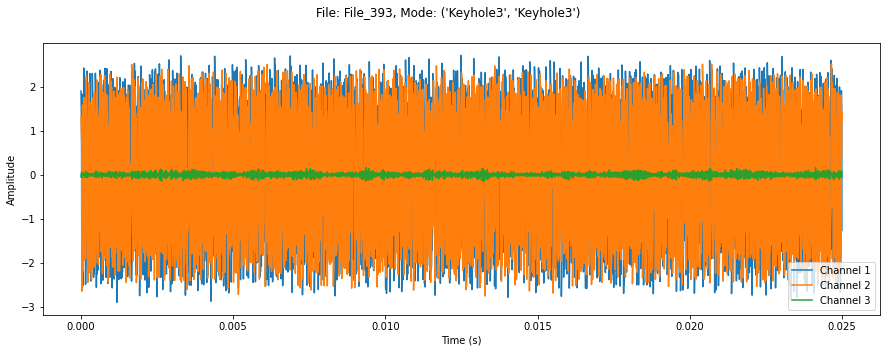

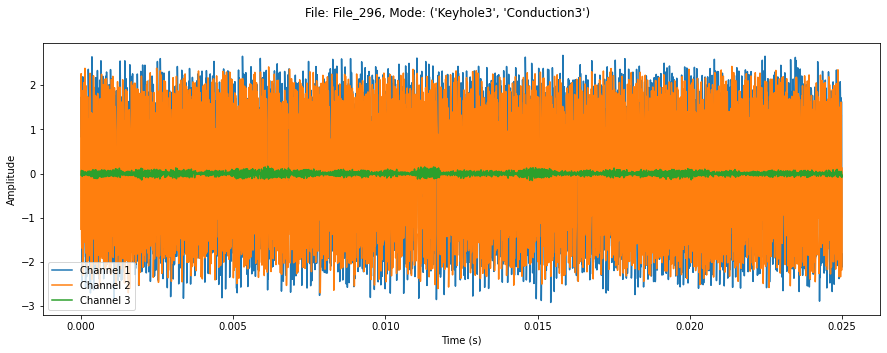

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import torch

# Select 2 random indexes from the training data
random_indexes = np.random.choice(train_data.size(0), 2, replace=False)

# Sampling frequency
Fs = 200000  # 200kHz

# Plot the selected files including file name and mode description
for idx in random_indexes:
    sim_signal = train_data[idx]  # Extract the sim_tensor for the selected index
    time_vector = np.linspace(0, sim_signal.size(1) / Fs, sim_signal.size(1), endpoint=False)  # Time vector
    file_name = train_names[idx]  # Extract file name
    mode_description = train_modes[idx]  # Extract mode description

    plt.figure(figsize=(15, 5))
    plt.suptitle(f"File: {file_name}, Mode: {mode_description}")

    # Plot each channel
    for i in range(sim_signal.size(0)):  
        plt.plot(time_vector, sim_signal[i].numpy(), label=f"Channel {i+1}")
    
    plt.xlabel("Time (s)")
    plt.ylabel("Amplitude")
    plt.legend()
    plt.show()


In [10]:
# Set random seed for reproducibility
random_seed = 42
random.seed(random_seed)
np.random.seed(random_seed)
torch.manual_seed(random_seed)


In [11]:
from torch.utils.data import Dataset, DataLoader

class CustomDataset(Dataset):
    def __init__(self, data, modes, names):
        """
        Args:
            data (Tensor): A tensor containing the data.
            modes (list): A list of mode descriptions for each sample.
            names (list): A list of file names for each sample.
        """
        self.data = data
        self.modes = modes
        self.names = names

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        sample = self.data[idx]
        mode = self.modes[idx]
        name = self.names[idx]
        return sample, mode, name


In [12]:
# Create dataset instances
train_dataset = CustomDataset(train_data, train_modes_int, train_names)
test_dataset = CustomDataset(test_data, test_modes_int, test_names)

# Create DataLoader instances
batch_size = 64  # Define your batch size
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


In [13]:
input_channels = 3  
filter_size = 51  
win_len = train_data.shape[-1]  

model = SignalClassifier(input_channels=input_channels, filter_size=filter_size, win_len=win_len)


In [14]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


In [15]:
# Define the loss function
loss_function = nn.BCEWithLogitsLoss()


In [16]:
model.to(device)

SignalClassifier(
  (conv1): Conv1d(3, 2, kernel_size=(51,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(51,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  )
  (branch1_bns): ModuleList(
    (0-1): 2 x BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch1_prelus): ModuleList(
    (0-1): 2 x PReLU(num_parameters=1)
  )
  (out_branch1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  (fc1_branch1): Linear(in_features=40000, out_features=128, bias=True)
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (branch2_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(51,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  )
  (branch2_bns): ModuleLis

In [17]:
# Optimizer
optimizer = optim.Adam(model.parameters(), lr=0.00001, weight_decay=0.001)

In [18]:
def train(model, device, train_loader, optimizer, loss_function):
    model.train()
    total_loss = 0
    for batch_idx, (data, (target1, target2), _) in enumerate(train_loader):  
        data = data.to(device)
        target1, target2 = target1.to(device).float(), target2.to(device).float()  
        
        optimizer.zero_grad()
        
        output1, output2 = model(data)  
        
        # Compute loss separately for each output
        loss1 = loss_function(output1.squeeze(), target1)
        loss2 = loss_function(output2.squeeze(), target2)
        
        # Sum the losses
        combined_loss = loss1 + loss2
        
        combined_loss.backward()  # Backpropagate the total loss
        optimizer.step()
        
        # Update running total_loss
        total_loss += combined_loss.item()
    
    avg_loss = total_loss / len(train_loader)
    print(f'Training loss: {avg_loss:.4f}')


In [19]:
def evaluate(model, device, test_loader, loss_function):
    model.eval()
    total_loss = 0
    correct1, correct2, total_samples = 0, 0, 0
    with torch.no_grad():
        for data, (target1, target2), _ in test_loader:
            data = data.to(device)
            target1, target2 = target1.to(device).float(), target2.to(device).float()
            
            output1, output2 = model(data)
            
            loss1 = loss_function(output1.squeeze(), target1)
            loss2 = loss_function(output2.squeeze(), target2)
            total_loss += (loss1 + loss2).item()
            
            sig_output1 = torch.sigmoid(output1).squeeze()
            sig_output2 = torch.sigmoid(output2).squeeze()

            pred1 = sig_output1 > 0.5
            pred2 = sig_output2 > 0.5

            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(target2.view_as(pred2)).sum().item()
            total_samples += target1.size(0)

    avg_loss = total_loss / len(test_loader)
    accuracy1 = correct1 / total_samples
    accuracy2 = correct2 / total_samples
    overall_accuracy = (accuracy1 + accuracy2) / 2  # Average accuracy across both outputs
    
    print(f'Test set: Average loss: {avg_loss:.4f}, Output 1 Accuracy: {accuracy1:.4f}, Output 2 Accuracy: {accuracy2:.4f}, Overall Accuracy: {overall_accuracy:.4f}')
    
    return overall_accuracy  # Return the overall accuracy


In [20]:
# Hyperparameter ranges to explore
lr_values = [0.001, 0.0001, 0.00001]
weight_decay_values = [0.001, 0.0001, 0]
filter_sizes = [11, 51, 101]  

# Variables to store the best performance and corresponding hyperparameters
best_performance = -float('inf')  # Initialize with -inf as we want to maximize accuracy
best_lr = None
best_weight_decay = None
best_filter_size = None  # Track the best filter size
best_model_path = "best_model.pth"  # Path to save the best model

number_of_epochs = 100

# Update total combinations for logging
total_combinations = len(lr_values) * len(weight_decay_values) * len(filter_sizes)
combination_count = 0

for lr in lr_values:
    for weight_decay in weight_decay_values:
        for filter_size in filter_sizes:  # Iterate over filter_sizes
            combination_count += 1
            print(f"\nEvaluating combination {combination_count}/{total_combinations}: lr={lr}, weight_decay={weight_decay}, filter_size={filter_size}")
            
            # Reinitialize the model with the current hyperparameters including filter_size
            model = SignalClassifier(input_channels=input_channels, filter_size=filter_size, win_len=win_len).to(device)
            optimizer = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)
            
            # Training loop
            for epoch in range(number_of_epochs):
                print(f"Training Epoch: {epoch+1}/{number_of_epochs} (lr={lr}, weight_decay={weight_decay}, filter_size={filter_size})")
                train(model, device, train_loader, optimizer, loss_function)
            
            # Evaluation evaluate() returns overall accuracy
            performance = evaluate(model, device, test_loader, loss_function)
            
            print(f"Evaluation complete - Accuracy: {performance:.4f}")
            
            # Update best performance, hyperparameters, and save the model if current model is better
            if performance > best_performance:
                best_performance = performance
                best_lr = lr
                best_weight_decay = weight_decay
                best_filter_size = filter_size  # Update the best filter size
                
                # Save the best model
                torch.save(model.state_dict(), best_model_path)
                print(f"New best model saved with accuracy: {best_performance:.4f}, lr: {best_lr}, weight_decay: {best_weight_decay}, filter_size={best_filter_size}")

# Print the best set of hyperparameters
print(f"\nOptimization Complete. Best Learning Rate: {best_lr}, Best Weight Decay: {best_weight_decay}, Best Filter Size: {best_filter_size}, Best Performance: {best_performance:.4f}")



Evaluating combination 1/27: lr=0.001, weight_decay=0.001, filter_size=11
Training Epoch: 1/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.9396
Training Epoch: 2/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.3481
Training Epoch: 3/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.1768
Training Epoch: 4/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.0965
Training Epoch: 5/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.0892
Training Epoch: 6/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.1039
Training Epoch: 7/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.0639
Training Epoch: 8/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.0592
Training Epoch: 9/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.1537
Training Epoch: 10/100 (lr=0.001, weight_decay=0.001, filter_size=11)
Training loss: 0.0841
Training Epoch

In [21]:
# To load the best model after the loop
model = SignalClassifier(input_channels=input_channels, filter_size=best_filter_size, win_len=win_len).to(device)
model.load_state_dict(torch.load(best_model_path))
model.eval()  # Set the model to evaluation mode


SignalClassifier(
  (conv1): Conv1d(3, 2, kernel_size=(51,), stride=(1,), padding=same)
  (bn1): BatchNorm1d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (prelu1): PReLU(num_parameters=1)
  (branch1_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(51,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  )
  (branch1_bns): ModuleList(
    (0-1): 2 x BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (branch1_prelus): ModuleList(
    (0-1): 2 x PReLU(num_parameters=1)
  )
  (out_branch1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  (fc1_branch1): Linear(in_features=40000, out_features=128, bias=True)
  (fc2_branch1): Linear(in_features=128, out_features=1, bias=True)
  (branch2_layers): ModuleList(
    (0): Conv1d(2, 8, kernel_size=(51,), stride=(1,), padding=same)
    (1): Conv1d(8, 8, kernel_size=(51,), stride=(1,), padding=same)
  )
  (branch2_bns): ModuleLis

In [22]:
from sklearn.metrics import precision_recall_fscore_support, roc_curve, auc, confusion_matrix
import matplotlib.pyplot as plt
import numpy as np

def evaluate(model, device, test_loader, loss_function):
    model.eval()
    total_loss = 0
    correct1, correct2 = 0, 0  # To track correct predictions for both outputs
    all_target1, all_target2 = [], []
    all_pred1, all_pred2 = [], []
    all_output1, all_output2 = [], []  # Lists to collect sigmoid-applied outputs for ROC
    
    with torch.no_grad():
        for data, (target1, target2), _ in test_loader:
            data = data.to(device)
            target1, target2 = target1.to(device).float(), target2.to(device).float()
            
            output1, output2 = model(data)
            
            # Calculate loss for each output
            loss1 = loss_function(output1.squeeze(), target1)
            loss2 = loss_function(output2.squeeze(), target2)
            total_loss += (loss1 + loss2).item()
            
            # Manually apply sigmoid to model outputs for accuracy calculation
            sig_output1 = torch.sigmoid(output1).squeeze()
            sig_output2 = torch.sigmoid(output2).squeeze()
            
            pred1 = sig_output1 > 0.5
            pred2 = sig_output2 > 0.5

            correct1 += pred1.eq(target1.view_as(pred1)).sum().item()
            correct2 += pred2.eq(target2.view_as(pred2)).sum().item()

            all_target1.append(target1.cpu())
            all_target2.append(target2.cpu())
            all_pred1.append(pred1.float().cpu())
            all_pred2.append(pred2.float().cpu())
            all_output1.append(sig_output1.cpu())  # Collect outputs for ROC
            all_output2.append(sig_output2.cpu())  # Collect outputs for ROC


    # Convert lists of tensors to single tensors
    all_target1 = torch.cat(all_target1)
    all_target2 = torch.cat(all_target2)
    all_pred1 = torch.cat(all_pred1)
    all_pred2 = torch.cat(all_pred2)
    all_output1 = torch.cat(all_output1)  # Outputs ready for ROC
    all_output2 = torch.cat(all_output2)  # Outputs ready for ROC
    
    # Calculate metrics
    precision1, recall1, f1_score1, _ = precision_recall_fscore_support(all_target1, all_pred1, average='binary')
    precision2, recall2, f1_score2, _ = precision_recall_fscore_support(all_target2, all_pred2, average='binary')
    
    print(f"Output 1 - Precision: {precision1:.4f}, Recall: {recall1:.4f}, F1 Score: {f1_score1:.4f}")
    print(f"Output 2 - Precision: {precision2:.4f}, Recall: {recall2:.4f}, F1 Score: {f1_score2:.4f}")
    
    # Individual accuracies
    accuracy1 = correct1 / len(all_target1)
    accuracy2 = correct2 / len(all_target2)
    print(f'Output 1 Accuracy: {accuracy1:.4f}, Output 2 Accuracy: {accuracy2:.4f}')
    
    # Plot ROC and Confusion Matrix
    plot_roc_and_confusion_matrix(all_target1, all_output1, "Output 1")
    plot_roc_and_confusion_matrix(all_target2, all_output2, "Output 2")

def plot_roc_and_confusion_matrix(targets, outputs, title):
    fpr, tpr, thresholds = roc_curve(targets, outputs)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'ROC Curve for {title}')
    plt.legend(loc="lower right")
    plt.show()

    # Calculate and plot confusion matrix
    preds_binary = outputs > 0.5
    cm = confusion_matrix(targets, preds_binary)
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Confusion Matrix for {title}')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Negative', 'Positive'], rotation=45)
    plt.yticks(tick_marks, ['Negative', 'Positive'])
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()


/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.25.2
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


Output 1 - Precision: 0.9786, Recall: 0.9947, F1 Score: 0.9866
Output 2 - Precision: 0.9788, Recall: 0.9231, F1 Score: 0.9501
Output 1 Accuracy: 0.9864, Output 2 Accuracy: 0.9516


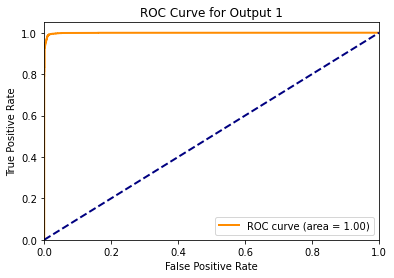

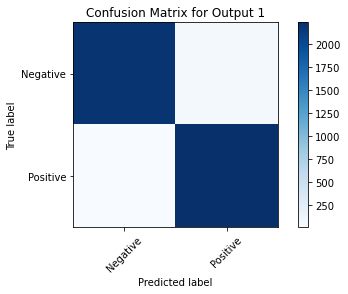

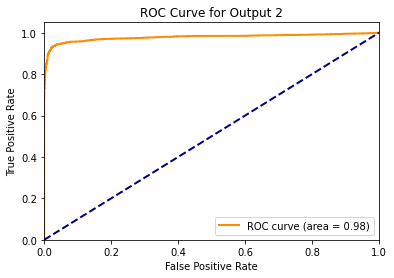

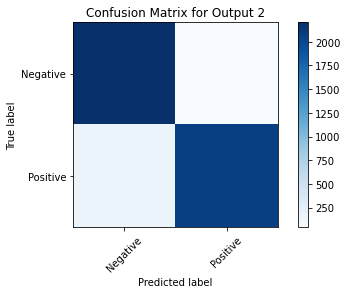

In [23]:
evaluate(model, device, test_loader, loss_function)